
## Overview

This notebook will show you how to create and query a table or DataFrame that you uploaded to DBFS. [DBFS](https://docs.databricks.com/user-guide/dbfs-databricks-file-system.html) is a Databricks File System that allows you to store data for querying inside of Databricks. This notebook assumes that you have a file already inside of DBFS that you would like to read from.

This notebook is written in **Python** so the default cell type is Python. However, you can use different languages by using the `%LANGUAGE` syntax. Python, Scala, SQL, and R are all supported.

In [58]:
!pip install --upgrade pip

In [59]:
!pip install -q tensorflow-recommenders


In [60]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_recommenders as tfrs
from tensorflow.keras import regularizers
import os
import tempfile
import sys
import numpy
import matplotlib


In [61]:
from google.colab import drive
drive.mount('/content/drive')
import os

os.chdir('/content/drive/MyDrive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
df = pd.read_csv('/content/drive/MyDrive/Book2.csv')
feature_names = ['identifier','poi','event_ts','fueltype','day']
features = df[feature_names].astype(str)
dataset = tf.data.Dataset.from_tensor_slices(dict(features))
poi_dataset = dataset.map(lambda x: x["poi"])
dataset = dataset.map(lambda x: {
    "identifier": (x["identifier"]),
    "poi": (x["poi"]),
    "event_ts": int(x["event_ts"]),
    "fueltype": (x["fueltype"]),
    "day": (x["day"]),
 })

print(len(dataset))




944


In [63]:
timestamps = np.concatenate(list(dataset.map(lambda x: x["event_ts"]).batch(100)))
max_timestamp = timestamps.max()
min_timestamp = timestamps.min()
timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,)
unique_user_ids = np.unique(np.concatenate(list(dataset.batch(1_000).map(
    lambda x: x["identifier"]))))
unique_fueltype_ids = np.unique(np.concatenate(list(dataset.batch(1_000).map(
    lambda x: x["fueltype"]))))
unique_day_ids = np.unique(np.concatenate(list(dataset.batch(1_000).map(
    lambda x: x["day"]))))
unique_poi_ids = np.unique(np.concatenate(list(poi_dataset.batch(1_000))))


In [64]:
class PoiModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.poi_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_poi_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_poi_ids) + 1, 32)
    ])

  def call(self,titles):

    return self.poi_embedding(titles)

In [65]:
class UserModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
        ])

        self.day_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_day_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_day_ids) + 1, 32),
        ])

        #self.fueltype_embedding = tf.keras.Sequential([
            #tf.keras.layers.StringLookup(
                #vocabulary=unique_fueltype_ids, mask_token=None),

            #tf.keras.layers.Embedding(len(unique_fueltype_ids) + 1, 32),
        #])

        #self.timestamp_embedding = tf.keras.Sequential([
            #tf.keras.layers.Discretization(timestamp_buckets.tolist()),
            #tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
        #])
        #self.normalized_timestamp = tf.keras.layers.Normalization(axis=None)

        #self.normalized_timestamp.adapt(timestamps)

    def call(self, inputs):

       return tf.concat([
        self.user_embedding(inputs["identifier"]),
        self.day_embedding(inputs["day"]),
        #self.fueltype_embedding(inputs["fueltype"]),
        #self.timestamp_embedding(inputs["event_ts"]),
        #tf.reshape(self.normalized_timestamp(inputs["event_ts"]), (-1, 1)),
        ], axis=1)


In [66]:
class QueryModel(tf.keras.Model):
 def __init__(self, layer_sizes):

  super().__init__()


  self.embedding_model = UserModel()


  self.dense_layers = tf.keras.Sequential()


  for layer_size in layer_sizes[:-1]:


      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))


  for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

 def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

In [67]:
class CandidateModel(tf.keras.Model):


  def __init__(self, layer_sizes):

    super().__init__()

    self.embedding_model = PoiModel()


    self.dense_layers = tf.keras.Sequential()


    for layer_size in layer_sizes[:-1]:

      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))


    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

In [68]:
class MainModel(tfrs.models.Model):


    def __init__(self, layer_sizes):
      super().__init__()
      self.query_model = QueryModel(layer_sizes)
      self.candidate_model = CandidateModel(layer_sizes)

      self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=poi_dataset.batch(128).map(self.candidate_model),
        ),
    )

    def compute_loss(self, features, training=False):

     query_embeddings = self.query_model({
        "identifier":features["identifier"],
        #"event_ts":features["event_ts"],
        #"fueltype":features["fueltype"],
        "day":features["day"],
      })

     poi_embeddings = self.candidate_model(
       features["poi"]
         )


     return self.task(query_embeddings,poi_embeddings)

In [69]:
for i in range(5):


  tf.random.set_seed(1234)
  shuffled = dataset.shuffle(944, seed=42, reshuffle_each_iteration=False)
  train = shuffled.take(755)
  test = shuffled.skip(755).take(189)
  cached_train = train.shuffle(755).batch(32)
  cached_test = test.batch(32).cache()


  model = MainModel([32])
  model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

  one_layer_history=model.fit(cached_train, epochs=50)

  train_accuracy = model.evaluate(
      cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
  test_accuracy = model.evaluate(
      cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

  print(f"Top-100 accuracy (train): {train_accuracy:.2f}.")
  print(f"Top-100 accuracy (test): {test_accuracy:.2f}.")


Epoch 1/50
24/24 [==============================] - 6s 171ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0940 - factorized_top_k/top_5_categorical_accuracy: 0.0940 - factorized_top_k/top_10_categorical_accuracy: 0.0993 - factorized_top_k/top_50_categorical_accuracy: 0.1510 - factorized_top_k/top_100_categorical_accuracy: 0.2265 - loss: 94.6547 - regularization_loss: 0.0000e+00 - total_loss: 94.6547
Epoch 2/50
24/24 [==============================] - 4s 176ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1232 - factorized_top_k/top_5_categorical_accuracy: 0.1351 - factorized_top_k/top_10_categorical_accuracy: 0.1642 - factorized_top_k/top_50_categorical_accuracy: 0.2980 - factorized_top_k/top_100_categorical_accuracy: 0.3987 - loss: 82.6390 - regularization_loss: 0.0000e+00 - total_loss: 82.6390
Epoch 3/50
24/24 [==============================] - 7s 293ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1152 - factorized_top_k/top_5_categorical_accuracy: 0.1391 - 

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

<ipython-input-70-444997ff90a3>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


[0.20397351682186127, 0.3907284736633301, 0.4887417256832123, 0.565562903881073, 0.564238429069519, 0.5695364475250244, 0.5933774709701538, 0.6066225171089172, 0.6013244986534119, 0.6238410472869873, 0.6092715263366699, 0.6437085866928101, 0.62649005651474, 0.6278145909309387, 0.62649005651474, 0.6132450103759766, 0.6357616186141968, 0.625165581703186, 0.6039735078811646, 0.6304636001586914, 0.6158940196037292, 0.6238410472869873, 0.6317880749702454, 0.6357616186141968, 0.6370860934257507, 0.6105960011482239, 0.6529801487922668, 0.6503311395645142, 0.6211920380592346, 0.6635761857032776, 0.6185430288314819, 0.6211920380592346, 0.6728476881980896, 0.6317880749702454, 0.6609271764755249, 0.6304636001586914, 0.6198675632476807, 0.6410595774650574, 0.6556291580200195, 0.6596026420593262, 0.6450331211090088, 0.6927152276039124, 0.6609271764755249, 0.6437085866928101, 0.6437085866928101, 0.6450331211090088, 0.6662251949310303, 0.6529801487922668, 0.6490066051483154, 0.6238410472869873]
50


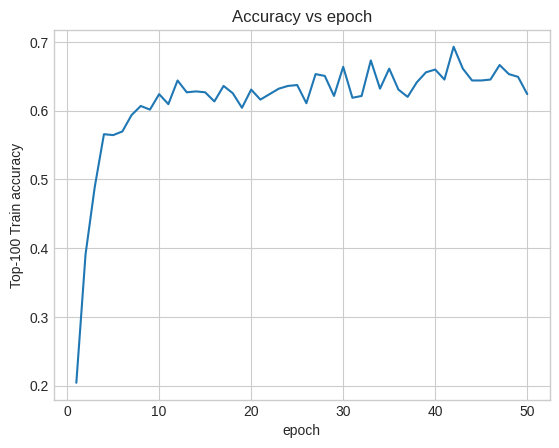

In [71]:
num_validation_runs = len(one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1) for x in range(num_validation_runs)]
print(one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"])
plt.plot(epochs, one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"])
print(num_validation_runs)
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 Train accuracy")
plt.legend()